In [139]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import Basemap
import pandas as pd
import networkx as nx
import param
from datetime import datetime, timedelta, date
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import *
from itertools import chain
import skimage
from math import floor

In [146]:
df_airport = pd.read_csv('airports.csv')
df = pd.read_csv('airline_1.csv')

## Select flight data in the first week of January in 1997
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.loc[(df['Month'] == 1) & (df['DayofMonth'] < 6)].dropna()
df['DepTime'] = df['DepTime'].apply(floor)
df['ArrTime'] = df['ArrTime'].apply(floor)
df['ArrDateTime'] = ""
df['DepDateTime'] = ""
df = df.reset_index()

## Change Time data to Datetime Frame
for row in df.itertuples():
    df.at[row[0],'DepDateTime'] = datetime(1997, row[2], row[3], (row[5] // 100) % 24, row[5] % 100)
    df.at[row[0],'ArrDateTime'] = datetime(1997, row[2], row[3], (row[6] // 100) % 24, row[6] % 100)

df_airport['InGraph'] = df_airport['IATA'].isin(set(dict(df['Origin']).values())) | df_airport['IATA'].isin(set(dict(df['Dest']).values()))
new_df_airport = df_airport[df_airport['InGraph'] == 1]

In [147]:
graph = nx.from_pandas_edgelist(df, source = 'Origin', target = 'Dest',create_using = nx.MultiGraph)
graph.remove_node('DUT')
nodes = new_df_airport[['IATA','LONGITUDE','LATITUDE']]
nodes = nodes.rename(columns = {'IATA': 'name', 'LONGITUDE': 'x', 'LATITUDE': 'y' })
edges = pd.DataFrame(graph.edges)
edges = edges.rename(columns = {0 : 'source', 1 : 'target'})

In [194]:
df_airport

,IATA,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,InGraph
0,ABQ,Albuquerque International,Albuquerque,NM,USA,35.040222,-106.609194,True
1,ANC,Ted Stevens Anchorage International,Anchorage,AK,USA,61.174320,-149.996186,True
2,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944,True
3,AUS,Austin-Bergstrom International,Austin,TX,USA,30.194533,-97.669872,True
4,BDL,Bradley International,Windsor Locks,CT,USA,41.938874,-72.683228,True
...,...,...,...,...,...,...,...,...
336,WRG,Wrangell,Wrangell,AK,USA,56.484326,-132.369824,True
337,WYS,Yellowstone,West Yellowstone,MT,USA,44.688399,-111.117638,False
338,XNA,Northwest Arkansas Regional,Fayetteville Springdale Rogers,AR,USA,36.281869,-94.306811,False
339,YAK,Yakutat,Yakutat,AK,USA,59.503361,-139.660226,True


In [148]:
## Edge List Generating
node_num_dict = dict([(k,v) for k, v in zip(nodes['name'],range(0,200))])

for items in node_num_dict:
    for ind, row in zip(edges.index, edges['source']):
        if row == items:
            edges.at[ind,'source'] = node_num_dict[items]
for items in node_num_dict:
    for ind, row in zip(edges.index, edges['target']):
        if row == items:
            edges.at[ind,'target'] = node_num_dict[items]

In [149]:
cvsopts = dict(plot_height=400, plot_width=600)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)


CPU times: user 1min 14s, sys: 1min 14s, total: 2min 29s
Wall time: 1min 31s


KDEEB

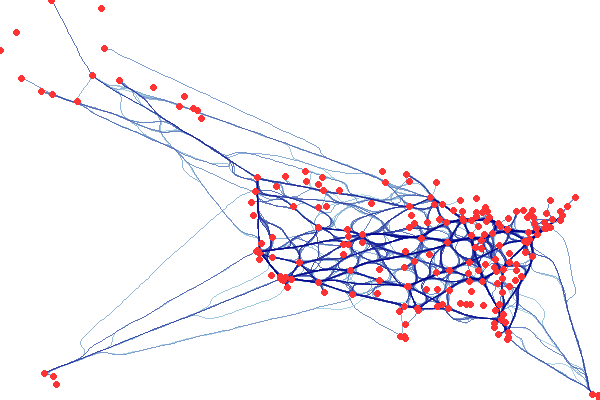

In [150]:
%time KDEEB = graphplot(nodes, hammer_bundle(nodes,edges,initial_bandwidth = 0.015), "KDEEB")
tf.Images(KDEEB)

In [145]:
edges

,source,target,2
0,0,53,0
1,0,53,1
2,0,53,2
3,0,53,3
4,0,53,4
...,...,...,...
70157,112,90,17
70158,112,90,18
70159,112,90,19
70160,112,90,20


In [134]:
start = datetime(1997,1,1,0,0)
end = datetime(1997,1,6,0,0)


In [189]:

# The step size of datatime
def Drange(start, end):
    # for n in range(int((end-start).days) * 24 + int((end-start).seconds / 3600)):
    for n in range(int((end-start).days) * 4 + 1):
        yield start + timedelta(hours = 6 * n)

df_list = []
for moments in Drange(start, end):
    dft = df[(df['DepDateTime'] < moments) & (df['ArrDateTime'] > moments)]
    df_list.append(dft)
